Reading logs from ../logs/V1
Reading logs from ../logs/V2-1
Reading logs from ../logs/V2
Classifying malicious_ransomwarePOC_10min_1.log as malicious, 13383 malicious entries found
Classifying malicious_ransomwarePOC_10min.log as malicious, 14477 malicious entries found
Classifying malicious_JavaRansomware_30min.log as malicious, 45982 malicious entries found
Classifying malicious_RAASNet-AES_60min.log as malicious, 10348 malicious entries found
Classifying malicious_ransim_20min.log as malicious, 23227 malicious entries found
Classifying malicious_RAASNet-Crypto_20min.log as malicious, 20069 malicious entries found
Classifying malicious_roar-ChaCha20_60min.log as malicious, 33968 malicious entries found
Classifying malicious_roar-AES-CTR_60min.log as malicious, 71676 malicious entries found
Classifying malicious_ransim-slow_60min.log as malicious, 23621 malicious entries found
Classifying malicious_cry_20min.log as malicious, 8185 malicious entries found
Classifying malicious_ransim-s

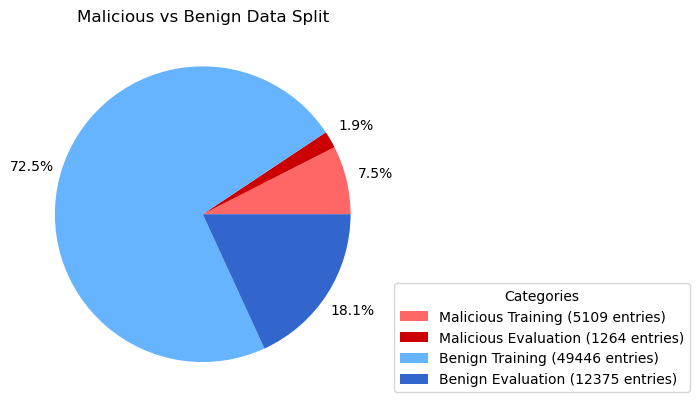

In [30]:
# V2 data overview
from log_reader import read_all_logs
from preprocessors.preprocessor import Preprocessor
import matplotlib.pyplot as plt
from train_models import train_test_split_df

df = read_all_logs(version=2)
df = Preprocessor.get(version=2).preprocess(df)

X_train, X_test, y_train, y_test = train_test_split_df(df)

# Count the number of malicious and non-malicious entries
malicious_train_count = y_train.sum()
malicious_test_count = y_test.sum()
malicious_count = malicious_train_count + malicious_test_count
non_malicious_train_count = len(y_train) - malicious_train_count
non_malicious_test_count = len(y_test) - malicious_test_count
non_malicious_count = non_malicious_train_count + non_malicious_test_count

# Create labels and sizes for the pie chart
labels = [f'Malicious ({malicious_count} entries)', f'Non-Malicious ({non_malicious_count} entries)']
sizes = [malicious_count, non_malicious_count]
colors_split = ['#FF6666', '#CC0000', '#66B3FF', '#3366CC']

labels = [f'Malicious Training ({malicious_train_count} entries)', f'Malicious Evaluation ({malicious_test_count} entries)', f'Benign Training ({non_malicious_train_count} entries)', f'Benign Evaluation ({non_malicious_test_count} entries)']
sizes = [malicious_train_count, malicious_test_count, non_malicious_train_count, non_malicious_test_count]

wedges, texts, autotexts  = plt.pie(sizes, autopct='%1.1f%%', pctdistance=1.2, colors=colors_split)
plt.title('Malicious vs Benign Data Split')
plt.legend(wedges, labels, title="Categories", loc="lower left", bbox_to_anchor=(1, 0, 0.5, 1))

#plt.savefig('v2_datasplit.png', dpi=300, bbox_inches='tight')
# Display the chart
plt.show()


In [28]:
# Best V1 models F1 score accross V2 logs
from train_models import load_model, train_test_split_df
from log_reader import read_logs_from_dir
from preprocessors.preprocessor import Preprocessor
from sklearn.metrics import f1_score


# Load models
iforest = load_model('models/trained/v1/v1_IForest_TfIdfVectorizer_2_2.pkl')
lof = load_model('models/trained/v1/v1_LOF_CountVectorizer_3_3.pkl')
nb = load_model('models/trained/v1/v1_NB_CountVectorizer_5_5.pkl')
rf = load_model('models/trained/v1/v1_RF_TfIdfVectorizer_5_5.pkl')

# Load data
df = read_logs_from_dir('../logs/V2')
preprocessor = Preprocessor.get(version=1)
df = preprocessor.preprocess(df)
X_train, X_test, y_train, y_test = train_test_split_df(df)

y_pred_iforest = iforest.predict(X_test)
y_pred_lof = lof.predict(X_test)
y_pred_nb = nb.predict(X_test)
y_pred_rf = rf.predict(X_test)

print(f'IForest F1 score: {f1_score(y_test, y_pred_iforest)}')
print(f'LOF F1 score: {f1_score(y_test, y_pred_lof)}')
print(f'NB F1 score: {f1_score(y_test, y_pred_nb)}')
print(f'RF F1 score: {f1_score(y_test, y_pred_rf)}')

Classifying malicious_ransim-slow_30min.log as malicious, 8586 malicious entries found
Classifying malicious_ransim_10min.log as malicious, 3221 malicious entries found
Classifying malicious_roar-ChaCha20_60min.log as malicious, 32965 malicious entries found
Classifying malicious_JavaRansomware_15min.log as malicious, 15232 malicious entries found
Classifying malicious_cry_10min.log as malicious, 4776 malicious entries found
Classifying malicious_roar-AES-CTR_60min.log as malicious, 47470 malicious entries found
Classifying malicious_RAASNet-Crypto_15min.log as malicious, 10145 malicious entries found
Classifying malicious_RAASNet-AES_30min.log as malicious, 4252 malicious entries found
IForest F1 score: 0.08029197080291971
LOF F1 score: 0.6102117061021171
NB F1 score: 0.1576923076923077
RF F1 score: 0.0


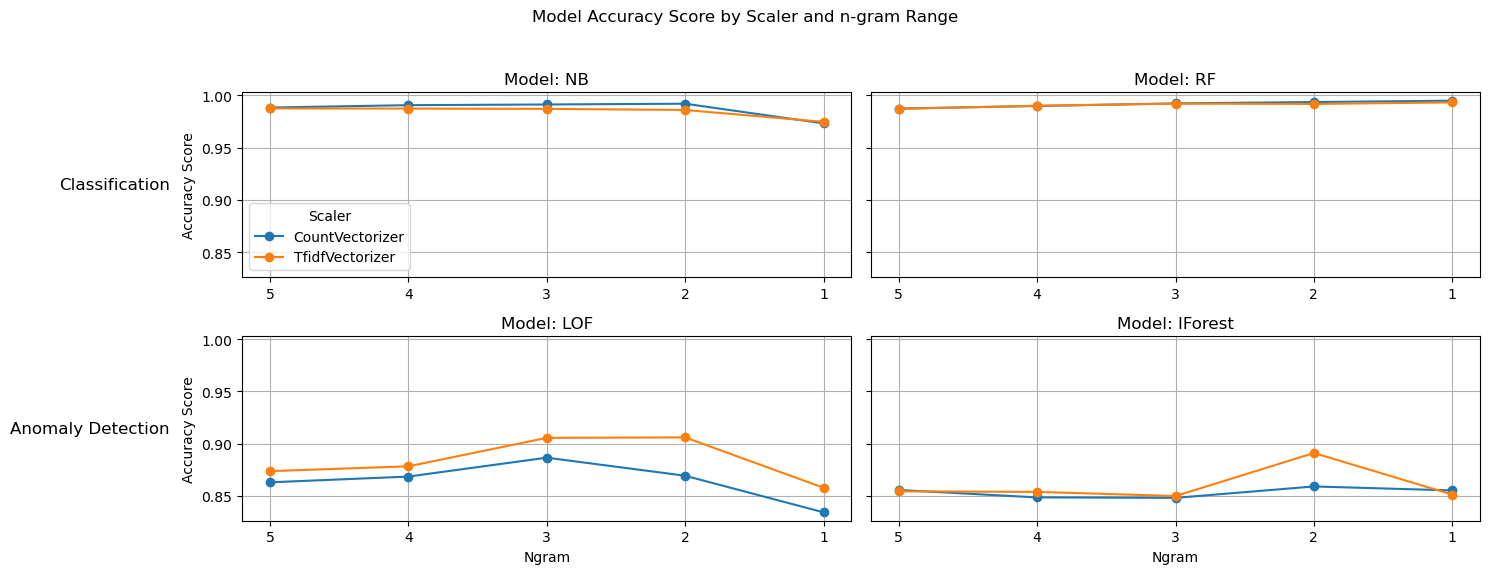

In [5]:
# V2 models accuracy scores
from train_models import load_scores
import matplotlib.pyplot as plt
import os

# Load model scores
models_dir = os.path.join(os.getcwd(), 'models/trained')
model_score = load_scores(version=2, output_dir=models_dir)

model_score = model_score.sort_values(['Min Ngram', 'Max Ngram'], ascending=[False, True])

# Create a figure with subplots for each model
types = model_score['Model_Type'].unique()
models = model_score['Model'].unique()
cols = int(len(models)/len(types))

models.sort()
fig, axs = plt.subplots(len(types), cols, figsize=(15, 6), sharey=True) 
for i, type in enumerate(types):
    ax_row = axs[i]
    for ax, model in zip(ax_row, model_score[model_score['Model_Type'] == type]['Model'].unique()):
        df_model = model_score[model_score['Model'] == model]
        for label, df_grouped in df_model.groupby('Scaler'):
            ax.plot(df_grouped['Min Ngram'].astype(str), 
                    df_grouped['Score'], label=label, marker='o')
        ax.set_title(f'Model: {model}')
        ax.grid(True)
    # Add row title
    axs[i][0].annotate(type, xy=(0, 0.5), xytext=(-axs[i][0].yaxis.labelpad - 5, 0),
                       xycoords=axs[i][0].yaxis.label, textcoords='offset points',
                       size='large', ha='right', va='center')
    axs[i][0].set_ylabel('Accuracy Score')
for i in range(cols):
    axs[-1][i].set_xlabel('Ngram')
axs[0][0].legend(title='Scaler')

plt.suptitle('Model Accuracy Score by Scaler and n-gram Range')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


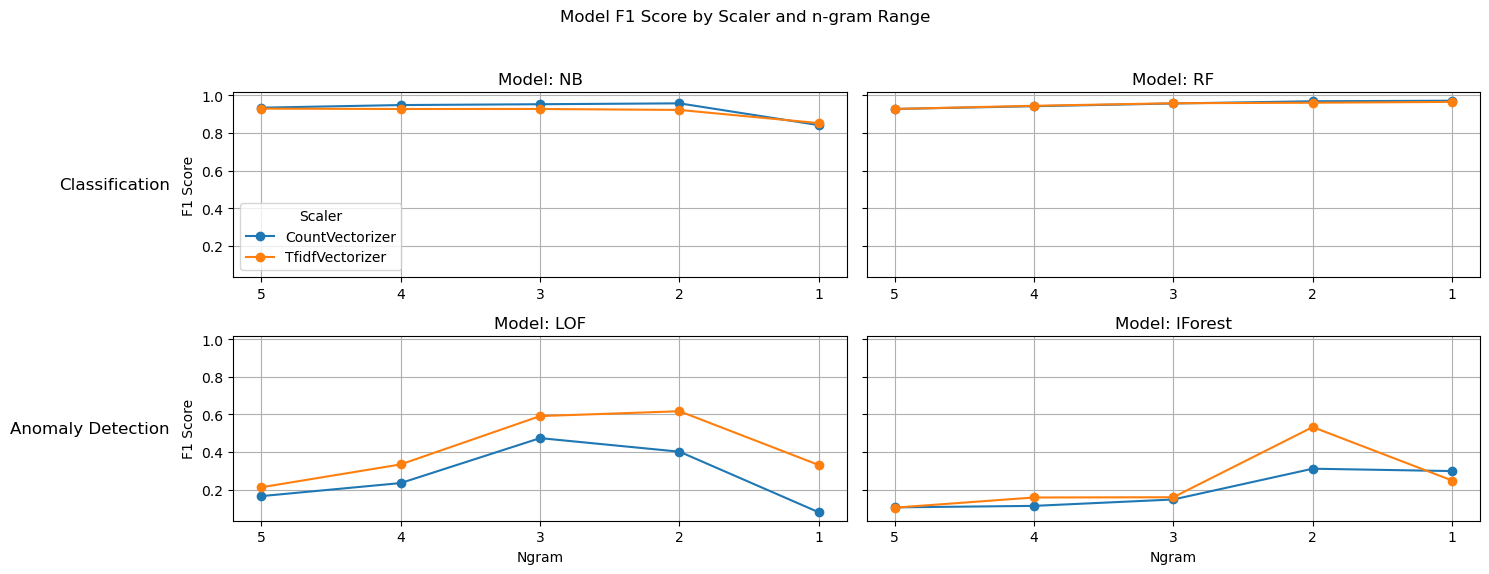

In [35]:
# V1 F1 models evaluation results
from train_models import load_scores
import matplotlib.pyplot as plt
import os

# Load model scores
models_dir = os.path.join(os.getcwd(), 'models/trained')
model_score = load_scores(version=2, output_dir=models_dir)

model_score = model_score.sort_values(['Min Ngram', 'Max Ngram'], ascending=[False, True])

# Create a figure with subplots for each model
types = model_score['Model_Type'].unique()
models = model_score['Model'].unique()
cols = int(len(models)/len(types))

models.sort()
fig, axs = plt.subplots(len(types), cols, figsize=(15, 6), sharey=True) 
for i, type in enumerate(types):
    ax_row = axs[i]
    for ax, model in zip(ax_row, model_score[model_score['Model_Type'] == type]['Model'].unique()):
        df_model = model_score[model_score['Model'] == model]
        for label, df_grouped in df_model.groupby('Scaler'):
            ax.plot(df_grouped['Min Ngram'].astype(str), 
                    df_grouped['F1'], label=label, marker='o')
        ax.set_title(f'Model: {model}')
        ax.grid(True)
    # Add row title
    axs[i][0].annotate(type, xy=(0, 0.5), xytext=(-axs[i][0].yaxis.labelpad - 5, 0),
                       xycoords=axs[i][0].yaxis.label, textcoords='offset points',
                       size='large', ha='right', va='center')
    axs[i][0].set_ylabel('F1 Score')
for i in range(cols):
    axs[-1][i].set_xlabel('Ngram')
axs[0][0].legend(title='Scaler')

plt.suptitle('Model F1 Score by Scaler and n-gram Range')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


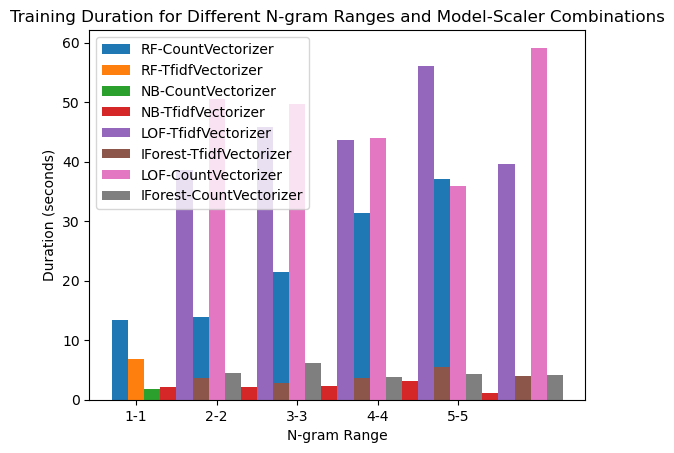

In [7]:
# V2 training durations
from train_models import load_scores
import matplotlib.pyplot as plt
import os

# Load models
models_dir = os.path.join(os.getcwd(), 'models/trained')
model_score = load_scores(version=2, output_dir=models_dir)

model_score['ngram range'] = model_score['Min Ngram'].astype(str) + "-" + model_score['Max Ngram'].astype(str)
model_score['Model-Scaler'] = model_score['Model'] + "-" + model_score['Scaler']
model_score.drop(columns=['Min Ngram', 'Max Ngram'], inplace=True)

ngram_ranges = model_score['ngram range'].unique()
model_vectorizer_combinations = model_score['Model-Scaler'].unique()

# Setting the position of bars on x-axis
bar_width = 0.2
positions = list(range(len(ngram_ranges)))

# Plotting each model-vectorizer combination for each n-gram range
for i, combination in enumerate(model_vectorizer_combinations):
    subset = model_score[model_score['Model-Scaler'] == combination]
    plt.bar([p + bar_width * i for p in positions], subset['Duration'], bar_width, label=combination)

plt.xlabel('N-gram Range')
plt.ylabel('Duration (seconds)')
plt.title('Training Duration for Different N-gram Ranges and Model-Scaler Combinations')
plt.xticks([p + bar_width for p in positions], ngram_ranges)
plt.legend()

In [27]:
# V2 best model performances
from train_models import load_scores
import os

# Load model scores
models_dir = os.path.join(os.getcwd(), 'models/trained')
model_score = load_scores(version=2, output_dir=models_dir)

# show best performing model per model
model_score = model_score.groupby('Model').apply(lambda x: x.nlargest(1, 'F1')).reset_index(drop=True)
model_score.sort_values('F1', ascending=False, inplace=True)
model_score

/var/folders/qm/bgf8w3t57rs0n48ykj9024nr0000gn/T/ipykernel_13662/4291620869.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  model_score = model_score.groupby('Model').apply(lambda x: x.nlargest(1, 'F1')).reset_index(drop=True)


,Score,Duration,F1,Recall,Precision,Model,Model_Type,Scaler,Min Ngram,Max Ngram
3,0.994794,13.693705,0.971474,0.986939,0.956487,RF,Classification,CountVectorizer,1,1
2,0.992082,1.910501,0.957514,0.952269,0.962816,NB,Classification,CountVectorizer,2,2
1,0.905932,44.853750,0.616442,0.495435,0.815665,LOF,Anomaly Detection,TfidfVectorizer,2,2
0,0.890974,3.484663,0.532243,0.441775,0.669304,IForest,Anomaly Detection,TfidfVectorizer,2,2
